# 200921 E coli genome similarity

In [1]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

In [2]:
from midas.kmers import KmerSpec, find_kmers_parse, vec_to_coords
from midas.cython.metrics import jaccard_coords
from midas.cython.seqs import coords_dtype

In [3]:
outdir = Path('../../data/processed/200921-ecoli-genome-similarity')
outdir.mkdir(exist_ok=True)

## Load/find data

### Sequences

In [4]:
seqdir = Path('/home/jared/projects/midas/data/2019_20/200919-ecoli-genomes-for-identity/')

In [5]:
seqfiles = sorted(seqdir.glob('*.fasta'))
nseqs = len(seqfiles)
nseqs

42

In [6]:
keys = [int(re.match(r'^SCU-(\d\d\d)', f.stem).group(1)) for f in seqfiles]

## Compute signatures and scores

In [7]:
kspec = KmerSpec(11, 'ATGAC')

In [8]:
sigs = [
    vec_to_coords(find_kmers_parse(kspec, f.open(), 'fasta')).astype(coords_dtype)
    for f in tqdm(seqfiles)
]

100%|██████████| 42/42 [00:08<00:00,  4.78it/s]


In [9]:
scores = np.ones((nseqs, nseqs))

for i in range(nseqs):
    for j in range(i):
        scores[i, j] = scores[j, i] = jaccard_coords(sigs[i], sigs[j])

Text(0.5, 1.05, 'Jaccard Similarity')

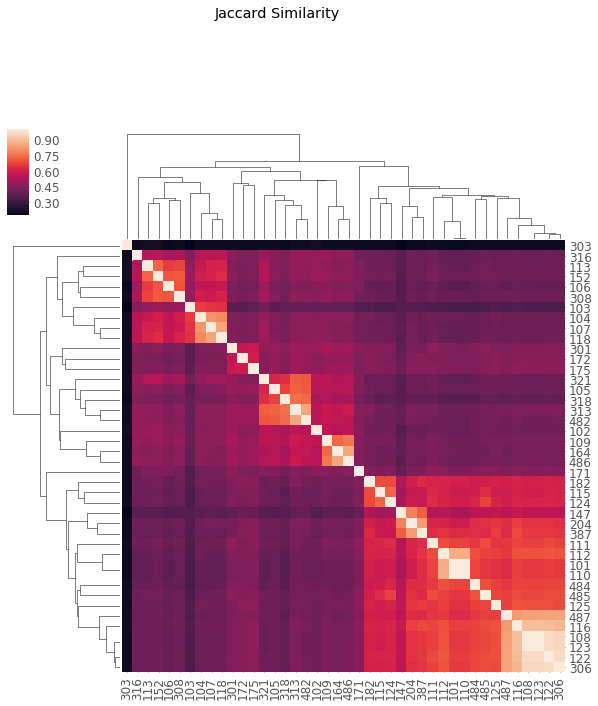

In [10]:
score_link = sch.linkage(squareform(1 - scores), method='average')
sns.clustermap(scores, xticklabels=keys, yticklabels=keys, row_linkage=score_link, col_linkage=score_link)
plt.suptitle('Jaccard Similarity', y=1.05)

## Write table

In [11]:
df_mat = pd.DataFrame(scores, columns=keys, index=keys)

In [12]:
df_mat.to_csv(outdir / '200921-ecoli-pairwise-similarity-matrix.csv')

In [13]:
df_ts = pd.DataFrame.from_records([(keys[i], keys[j], scores[i, j]) for i in range(nseqs) for j in range(i - 1)], columns=['genome1', 'genome2', 'similarity'])

In [14]:
df_ts.to_csv(outdir / '200921-ecoli-pairwise-similarity-tallskinny.csv')